In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pickle
%matplotlib inline

In [2]:
path = "/labs/mignot/DGN/BLAST"
zero_path = os.path.join(path, "zero")
one_path = os.path.join(path, "one")
two_path = os.path.join(path, "two")

In [3]:
f = open("/home/ashteng/allJCodes.txt", "r")
all_j_codes = set([x.strip() for x in f.readlines()])

In [4]:
genotype_name_path_dict = {"GG": zero_path, "GC": one_path, "CC": two_path}
genotype_name_dose_dict = {"GG": 0, "GC": 1, "CC": 2}

In [8]:
df = pd.DataFrame(columns=["patid", "genotype", "dose", "transcript", "count"])
for genotype in genotype_name_path_dict.keys(): # zero, one, two
    genotype_path = genotype_name_path_dict[genotype]
    for file in os.listdir(genotype_path): # for each person
        patid, extension = file[:-4], file[-4:]
        if extension == ".out":
            if os.path.exists("{}.fasta".format(patid)): # skip .out files where the fasta is still present, unfinished
                continue 
            filepath = os.path.join(genotype_path, file)
            # load each person's .out file into a separate dataframe
            raw_df = pd.read_csv(filepath, delimiter="\t", names=['qseqid', 'sseqid', 'pident', 'length', 'mismatch', 'gapopen', 'qstart', 'qend', 'sstart', 'send', 'evalue', 'bitscore'])
#             print(raw_df[raw_df['sseqid'].isin(["TRAJ24*01"])])
            # group by read id and only extract the maximum score read across families
            raw_df = raw_df.loc[raw_df.groupby(["qseqid"], sort=False)["pident"].idxmax()] 
            all_j_codes_dict = {x:0 for x in all_j_codes} # each person has a counts distribution over all J codes
            for index, row in raw_df.iterrows():
                match = row['sseqid']
                if match in all_j_codes_dict:
                    all_j_codes_dict[match] += 1
                else:
                    print("Error: unknown match {} from {}.".format(match, filepath))
            for j_code in all_j_codes_dict:
                df = df.append({"patid": patid, "genotype": genotype, "dose": genotype_name_dose_dict[genotype], "transcript": j_code, "count": all_j_codes_dict[j_code]}, ignore_index=True)

In [9]:
assert len(all_j_codes_dict) == len(df['transcript'].unique()) == len(df[df['patid'] == 'LD0420'])
df.to_csv("allJCounts2.txt")

In [5]:
df = pd.read_csv("allJCounts2.txt", index_col=0)

In [6]:
df = df[df['transcript'].str.startswith("TRA")] # only keep TRAJ

In [7]:
transcript_family_subtype_df = df["transcript"].str.split("*", n = 1, expand = True).rename(columns={0:"family", 1:"subtype"})

In [8]:
df["family"] = transcript_family_subtype_df["family"]
df["subtype"] = transcript_family_subtype_df["subtype"]

In [9]:
df

,patid,genotype,dose,transcript,count,family,subtype
0,LD0796,GG,0,TRAJ09*01,17,TRAJ09,01
1,LD0796,GG,0,TRAJ54*01,23,TRAJ54,01
2,LD0796,GG,0,TRAJ53*01,6,TRAJ53,01
4,LD0796,GG,0,TRAJ52*01,20,TRAJ52,01
5,LD0796,GG,0,TRAJ06*01,22,TRAJ06,01
...,...,...,...,...,...,...,...
70063,LD0691,CC,2,TRAJ34*01,17,TRAJ34,01
70064,LD0691,CC,2,TRAJ50*01,2,TRAJ50,01
70066,LD0691,CC,2,TRAJ15*02,0,TRAJ15,02
70069,LD0691,CC,2,TRAJ07*01,17,TRAJ07,01


In [11]:
# For comparison with Sharon
patid_family_counts_df = df[['patid', 'family', 'count']].groupby(['patid', 'family']).sum().reset_index()
pickle.dump(patid_family_counts_df, open("patid_family_count_df.pkl", "wb"))

In [12]:
patid_genotype_df = df[['patid', 'genotype', 'dose']].drop_duplicates()
patid_genotype_df.head()
patid_genotype_df.to_csv("patid_genotype.csv")

In [13]:
len(df.patid.unique())

922

In [14]:
total_j_count_df = df[["patid", "count"]].groupby("patid").sum().rename(columns={"count":"total_J_count"}).reset_index()
total_j_count_df.head()

,patid,total_J_count
0,LD0001,647
1,LD0002,926
2,LD0003,802
3,LD0006,1063
4,LD0007,1010


In [21]:
df_with_total = pd.merge(df, total_j_count_df, how="inner", on="patid")
df_with_total["ratio"] = df_with_total["count"]/df_with_total["total_J_count"]
df_with_total['patid'] = df_with_total['patid'].apply(lambda x: int(x[2:]))

In [22]:
df_with_total.head()

,patid,genotype,dose,transcript,count,family,subtype,total_J_count,ratio
0,796,GG,0,TRAJ09*01,17,TRAJ09,01,637,0.026688
1,796,GG,0,TRAJ54*01,23,TRAJ54,01,637,0.036107
2,796,GG,0,TRAJ53*01,6,TRAJ53,01,637,0.009419
3,796,GG,0,TRAJ52*01,20,TRAJ52,01,637,0.031397
4,796,GG,0,TRAJ06*01,22,TRAJ06,01,637,0.034537


In [23]:
all_j_ratios_df = df_with_total[["patid", "transcript", "ratio"]]

In [24]:
all_j_ratios_df.to_csv("allJRatios.csv")

Add covariates to DF

In [25]:
PCA_path = "/labs/mignot/GenRED.II.autosomalClean.Final.mds"
PCA_df = pd.read_csv(PCA_path, delim_whitespace=True)
PCA_df = PCA_df.drop("IID", axis=1)
PCA_df['patid'] = PCA_df['FID'].apply(lambda x: x.split("_")[-1])
PCA_df = PCA_df[PCA_df['patid'].str.startswith("LD")]
PCA_df['patid'] = PCA_df['patid'].apply(lambda x: int(x[2:]))
PCA_df = PCA_df.drop(["FID", "SOL"], axis=1)
PCA_df.head()

,C1,C2,C3,C4,C5,C6,C7,C8,C9,patid
0,-0.003309,0.014030,0.007670,-0.003006,0.008063,-0.008303,0.007457,-0.009014,0.009331,14
1,-0.040239,0.000318,-0.006434,-0.001362,-0.002399,-0.002950,-0.001922,-0.011280,0.004143,41
2,0.006729,0.007246,-0.002515,0.004305,-0.000373,-0.007282,0.002509,-0.008408,-0.007790,38
3,0.004359,-0.001416,-0.015182,-0.009998,0.000340,-0.005163,0.003465,0.004353,0.012437,84
4,0.004776,0.001741,-0.000872,0.002636,0.010817,0.010118,-0.002008,-0.005445,0.008797,22


In [24]:
df_with_total.head()

,patid,genotype,dose,transcript,count,family,subtype,total_J_count,ratio
0,796,GG,0,TRAJ09*01,17,TRAJ09,01,637,0.026688
1,796,GG,0,TRAJ54*01,23,TRAJ54,01,637,0.036107
2,796,GG,0,TRAJ53*01,6,TRAJ53,01,637,0.009419
3,796,GG,0,TRAJ52*01,20,TRAJ52,01,637,0.031397
4,796,GG,0,TRAJ06*01,22,TRAJ06,01,637,0.034537


In [25]:
patid_genotype_df['patid'] = patid_genotype_df['patid'].apply(lambda x: int(x[2:]))

In [26]:
def getPlotDf(query_transcripts, plot_column="ratio"):
    # query_transcripts can be single, or list of multiple, which will be summed together
    summed_plot_column_name = "summed_{}".format(plot_column)
    
    # filter out rows that match query_transcripts
    filtered_transcripts_df = df_with_total[df_with_total['transcript'].isin(query_transcripts)]
    
    # sum up all row values by groupby patid
    summed_filtered_transcripts_df = filtered_transcripts_df[['patid', plot_column]].groupby('patid').sum().reset_index().rename(columns={plot_column:summed_plot_column_name})
    
    # add metadata about genotypes and dose
    plot_df = pd.merge(summed_filtered_transcripts_df, patid_genotype_df)
    
    # normalize summed_count column within each class, creating new column normalized_summed_count
    normalized_summed_plot_column_name = 'normalized_{}'.format(summed_plot_column_name)
    plot_df[normalized_summed_plot_column_name] = (plot_df[summed_plot_column_name] - plot_df[summed_plot_column_name].mean()) / plot_df[summed_plot_column_name].std()

    # remove outliers (two sides) using the normalized_summed_count
    quantile_low, quantile_high = plot_df[normalized_summed_plot_column_name].quantile([0.025, 0.975]).values
    outliers_removed_plot_df = plot_df[(plot_df[normalized_summed_plot_column_name] > quantile_low) & (plot_df[normalized_summed_plot_column_name] < quantile_high)]
    
#     # remove outliers with hard threshold
#     outliers_removed_plot_df = plot_df[plot_df[summed_plot_column_name] <= 0.025]
    
    # join in covariates
    plot_df_with_covariates = pd.merge(outliers_removed_plot_df, PCA_df, on="patid", how="inner")
    
    return plot_df_with_covariates

In [27]:
def drawFamilyBoxPlots(plot_df, plot_column_name):    
    fig, ax = plt.subplots()
    sns.boxplot(x="genotype", y=plot_column_name, data=plot_df, order=["GG", "GC", "CC"], ax=ax)
    sns.regplot(x="dose", y=plot_column_name, data=plot_df, x_estimator=np.median, color="yellow", ax=ax, label="Median Estimator")
    #sns.scatterplot(x="dose", y=summed_plot_column, data=plot_df)
    plt.legend()
    plt.title("BLAST {} {}".format(query_transcripts, plot_column_name))

In [33]:
def drawFamilyViolinPlots(plot_df, plot_column_name):
    fig, ax = plt.subplots()
    sns.violinplot(x="genotype", y=plot_column_name, data=plot_df)
    plt.title("BLAST {} {}".format(query_transcripts, plot_column_name))

In [34]:
def regress(plot_df, plot_column_name, covariates=True):
    if covariates:
        X = plot_df.loc[:, ["dose", "C1", "C2", "C3", "C4"]].values
    else:
        X = plot_df.loc[:, ["dose"]].values
    y = plot_df[plot_column_name].values
    XX = sm.add_constant(X)
    mod = sm.OLS(y, XX)
    res = mod.fit()
    print('Parameters: ', res.params)
    print('R2: ', res.rsquared)
    print('p values:', res.pvalues)
    print(res.summary())

In [35]:
df_with_total.drop_duplicates('patid').groupby("genotype").count() # final cohort

,patid,dose,transcript,count,family,subtype,total_J_count,ratio
genotype,,,,,,,,
CC,24,24,24,24,24,24,24,24
GC,236,236,236,236,236,236,236,236
GG,662,662,662,662,662,662,662,662


Parameters:  [ 0.01473016 -0.0015947   0.01527505  0.03497551 -0.03605882  0.00627064]
R2:  0.028354909133989303
p values: [0.00000000e+00 2.45041783e-05 4.11390913e-01 8.77542602e-02
 1.66293097e-01 8.18405015e-01]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     5.066
Date:                Fri, 01 Nov 2019   Prob (F-statistic):           0.000139
Time:                        14:32:54   Log-Likelihood:                 3282.0
No. Observations:                 874   AIC:                            -6552.
Df Residuals:                     868   BIC:                            -6523.
Df Model:                           5                                         
Covariance Type:            nonrobust                                    

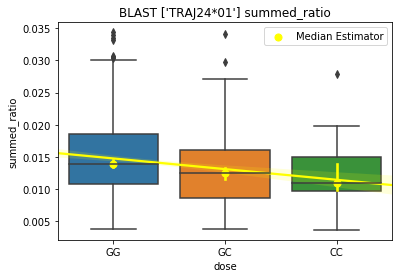

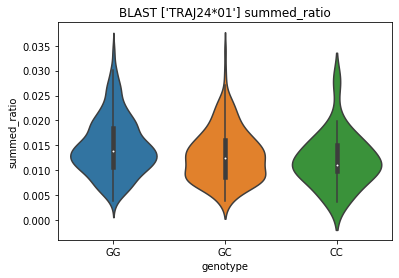

In [55]:
query_transcripts = ["TRAJ24*01"]
plot_df = getPlotDf(query_transcripts, "ratio")
plot_column_name = "summed_ratio"
regress(plot_df, plot_column_name)
drawFamilyBoxPlots(plot_df, plot_column_name)
drawFamilyViolinPlots(plot_df, plot_column_name)

Parameters:  [ 0.01676331  0.00218021  0.02114449  0.00056489  0.03599292 -0.01459216]
R2:  0.041426949274981584
p values: [0.00000000e+00 1.62254095e-08 2.58454255e-01 9.78326349e-01
 1.79931310e-01 6.01428648e-01]
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     7.503
Date:                Fri, 01 Nov 2019   Prob (F-statistic):           6.61e-07
Time:                        14:27:40   Log-Likelihood:                 3262.6
No. Observations:                 874   AIC:                            -6513.
Df Residuals:                     868   BIC:                            -6485.
Df Model:                           5                                         
Covariance Type:            nonrobust                                    

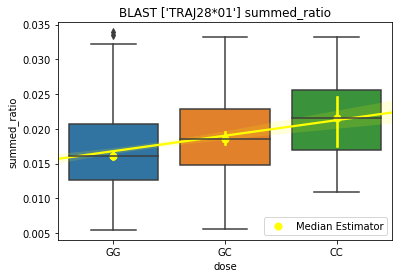

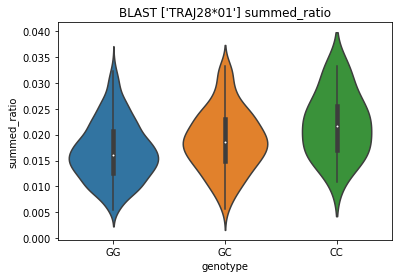

In [46]:
query_transcripts = ["TRAJ28*01"]
plot_df = getPlotDf(query_transcripts, "ratio")
plot_column_name = "summed_ratio"
regress(plot_df, plot_column_name)
drawFamilyBoxPlots(plot_df, plot_column_name)
drawFamilyViolinPlots(plot_df, plot_column_name)

In [47]:
plot_df

,patid,summed_ratio,genotype,dose,normalized_summed_ratio,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,1,0.012365,GG,0,-0.683025,0.009397,0.018055,-0.004716,0.010730,-0.011758,-0.005988,0.003570,-0.010644,0.005686
1,2,0.016199,GC,1,-0.202285,0.003468,-0.007170,-0.003461,-0.001816,-0.000123,0.000361,0.015604,-0.009396,0.000053
2,3,0.016209,GG,0,-0.200934,-0.043465,0.003659,-0.000466,-0.004065,0.000689,0.009372,-0.002002,-0.000158,0.000714
3,6,0.015992,GG,0,-0.228144,-0.022600,-0.002147,-0.011404,-0.004433,0.002490,0.003893,0.002319,0.005560,-0.003001
4,7,0.016832,GG,0,-0.122915,0.005851,-0.013256,0.013151,0.006337,-0.012097,0.005920,-0.007202,-0.003804,0.001051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869,1357,0.020952,GC,1,0.393782,0.004641,-0.004084,-0.007115,0.000198,-0.014810,0.002149,0.014409,0.004737,0.002471
870,1361,0.018826,GC,1,0.127170,0.005403,-0.010282,0.004311,0.005160,0.000340,0.002617,0.005842,0.000279,0.004005
871,1362,0.021036,GG,0,0.404216,0.005662,-0.010947,-0.003193,0.006493,0.010992,0.002510,0.005679,-0.001554,-0.003180
872,1364,0.014006,CC,2,-0.477279,0.002518,-0.012172,0.001717,0.005973,-0.001186,-0.000142,-0.003703,-0.002098,-0.001005


In [48]:
# Non Linear Model Testing

In [56]:
GG_arr = plot_df[plot_df['genotype'] == "GG"]['summed_ratio']
GC_arr = plot_df[plot_df['genotype'] == "GC"]['summed_ratio']
CC_arr = plot_df[plot_df['genotype'] == "CC"]['summed_ratio']
haveC_arr = np.concatenate((GC_arr.values, CC_arr.values))

In [57]:
import scipy

In [58]:
scipy.stats.mannwhitneyu(GG_arr, CC_arr)

MannwhitneyuResult(statistic=5153.5, pvalue=0.009081944070945088)

In [59]:
scipy.stats.mannwhitneyu(GG_arr, GC_arr)

MannwhitneyuResult(statistic=57171.5, pvalue=4.847064666949743e-05)

In [60]:
scipy.stats.mannwhitneyu(GC_arr, CC_arr)

MannwhitneyuResult(statistic=2263.0, pvalue=0.20303142489886805)

In [61]:
scipy.stats.mannwhitneyu(GG_arr, haveC_arr)

MannwhitneyuResult(statistic=62325.0, pvalue=8.976996676469751e-06)